In [1]:
import copy
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import time
import os

from neigh_gf_src import datasets as ds
from neigh_gf_src import graphutils as gu
from neigh_gf_src.arch import GraphDecoder, GCNN, SOTAGraphNN
from neigh_gf_src.model import ModelDenoising

SEED = 12
torch.manual_seed(SEED)
np.random.seed(SEED)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Test decoder with DW signal 

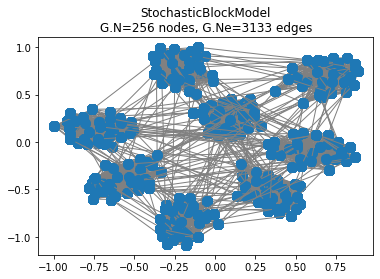

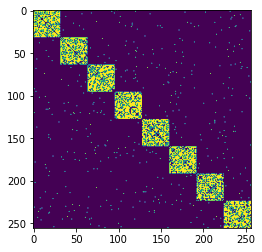

In [3]:
# Graph parameters
G_params = {}
G_params['type'] = gu.SBM
G_params['k'] = 8
G_params['type_z'] = gu.CONT
G_params['N'] = N = 256
G_params['p'] = 0.75
G_params['q'] = 0.0075

G = gu.create_graph(G_params, SEED)
S = np.asarray(G.W.todense())

G.plot()
plt.figure()
plt.imshow(S)

[0.13318287 0.63933657 0.22748056]


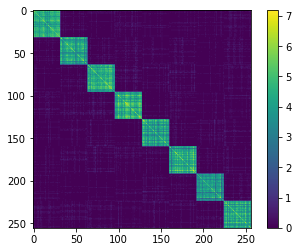

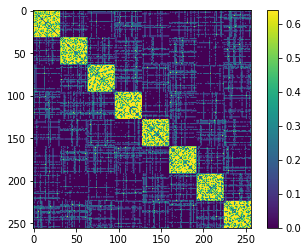

In [4]:
K = 3
hs = np.random.rand(K)
hs /= np.sum(hs)
print(hs)

h_params = {'type': 'FixedH', 'hs': hs, 'H_norm': False, 'neigh': False}
H = gu.create_filter(S, h_params)

plt.figure()
plt.imshow(H)
plt.colorbar()

h_params_n = {'type': 'FixedH', 'hs': hs, 'H_norm': False, 'neigh': True}
Hn = gu.create_filter(S, h_params_n)

plt.figure()
plt.imshow(Hn)
plt.colorbar()

In [5]:
Exps = [{'name': 'decoder', 'H': H, 'fts': 150, 'std': .1, 'legend': 'Arch. GF'},
        {'name': 'decoder', 'H': Hn, 'fts': 150, 'std': .1, 'legend': 'Arch. NGF'},
        {'name': 'GCNConv', 'fts': 150, 'legend': 'GCN'},
        {'name': 'SGConv', 'fts': 150, 'K': 2, 'legend': 'SGC'}]

n_signals = 200
n_p = 0.1
epochs = 1000
lr = 0.01

In [6]:
err = np.zeros((2*len(Exps), n_signals, epochs))
data_H = ds.DenoisingWhite(G, [n_signals]*3, n_p, H=H, median=False)
data_Hn = ds.DenoisingWhite(G, [n_signals]*3, n_p, H=Hn, median=False)

data_H.to_tensor(n_chans=0)
data_Hn.to_tensor(n_chans=0)

data_H.to(device)
data_Hn.to(device)

start_time = time.time()

print("Signals (total {}) - ".format(n_signals), end="")

for i in range(n_signals):
    
    x1 = data_H.val_Y[i,:]
    x1_n = data_H.train_Y[data_H.val_idx[i],:]
    x1_p = torch.linalg.vector_norm(x1).item()**2

    x2 = data_Hn.val_Y[i,:]
    x2_n = data_Hn.train_Y[data_Hn.val_idx[i],:]
    x2_p = torch.linalg.vector_norm(x2).item()**2    
    
    for j, exp in enumerate(Exps):
        if exp['name'] == 'decoder':
            arch = GraphDecoder(exp['fts'], exp['H'], exp['std'])
        else:
            arch = SOTAGraphNN(S, exp, [N, exp['fts'], 1])
            
        arch.to(device)
        
        model1 = ModelDenoising(copy.deepcopy(arch), epochs=epochs, learning_rate=lr)
        model2 = ModelDenoising(copy.deepcopy(arch), epochs=epochs, learning_rate=lr)

        _, err[2*j, i, :], _ = model1.fit(x1_n, x1)
        err[2*j, i, :] = err[2*j, i, :] / x1_p
        _, err[2*j+1, i, :], _ = model2.fit(x2_n, x2)
        err[2*j+1, i, :] = err[2*j+1, i, :] / x2_p
    
    print(i+1, end=' ')

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

Signals (total 200) - 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 
--- 86.51492005983988 minutes ---


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


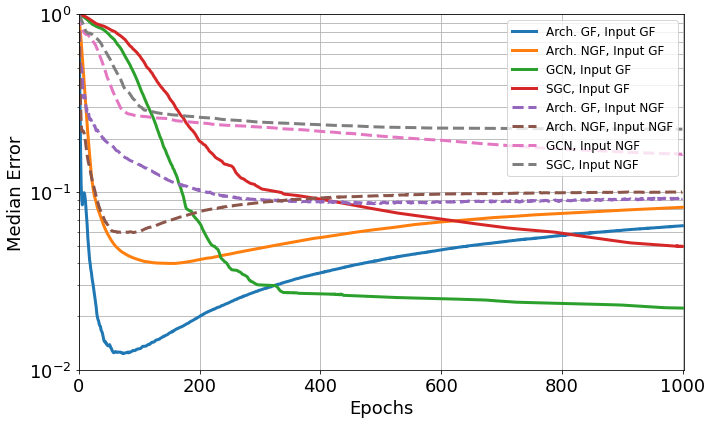

In [7]:
# No normalization
err_med = np.median(err, axis=1)

leg = []
for i, exp in enumerate(Exps):
    leg.append(exp['legend']+', Input GF')
for i, exp in enumerate(Exps):
    leg.append(exp['legend']+', Input NGF')

fig = plt.figure(figsize=(10,6))

for i in range(len(Exps)):
    plt.semilogy(err_med[2*i,:], '-', linewidth=3)
for i in range(len(Exps)):
    plt.semilogy(err_med[2*i+1,:], '--', linewidth=3)
plt.legend(leg, prop={'size': 12}, loc='upper right')
plt.grid(True, which='both')
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Median Error',fontsize=18)
plt.xlim([0, epochs+1])
plt.ylim([1e-2, 1])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

if not os.path.exists('images'):
    os.mkdir('images')
plt.savefig('images/denoising_2l.eps', format='eps')

# Modifying noise power

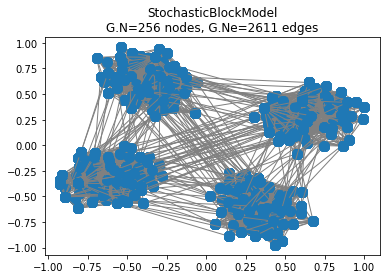

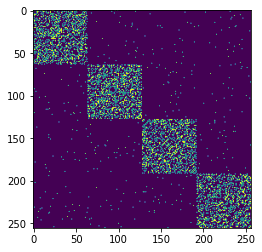

In [8]:
# Graph parameters
G_params = {}
G_params['type'] = gu.SBM
G_params['k'] = 4
G_params['type_z'] = gu.CONT
G_params['N'] = N = 256
G_params['p'] = 0.3
G_params['q'] = 0.0075

G = gu.create_graph(G_params, SEED)
S = G.W.todense()

G.plot()
plt.figure()
plt.imshow(S)

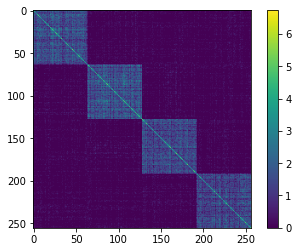

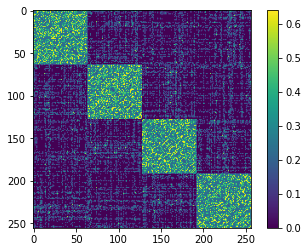

In [9]:
h_params = {'type': 'FixedH', 'hs': hs, 'H_norm': False, 'neigh': False}
H = gu.create_filter(S, h_params)

plt.figure()
plt.imshow(H)
plt.colorbar()

h_params_n = {'type': 'FixedH', 'hs': hs, 'H_norm': False, 'neigh': True}
Hn = gu.create_filter(S, h_params_n)

plt.figure()
plt.imshow(Hn)
plt.colorbar()

In [10]:
Exps = [{'name': 'gcnn', 'H': H, 'legend': 'Arch. GF'},
        {'name': 'gcnn', 'H': Hn, 'legend': 'Arch. NGF'},
        {'name': 'GCNConv', 'legend': 'GCN'},
        {'name': 'SGConv', 'K': 2, 'legend': 'SGC'}]

n_signals = 50
epochs = 1000
lr = 0.001
fts = [64]*3 + [1]
in_std = 0.1
w_std = 0.1

In [11]:
n_ps = [.025, .05, .1, .15, .2, .25]
n_perts = len(n_ps)

err1 = np.zeros((2*len(Exps), n_signals, epochs, n_perts))
min_err1 = np.zeros((2*len(Exps), n_signals, n_perts))
start_time = time.time()

for k, n_p in enumerate(n_ps):
    print("Starting with " + str(n_p) + ' - ', end="")

    data_H = ds.DenoisingWhite(G, [n_signals]*3, n_p, H=H, median=True, norm=True)
    data_Hn = ds.DenoisingWhite(G, [n_signals]*3, n_p, H=Hn, median=True, norm=True)

    data_H.to_tensor(n_chans=0)
    data_Hn.to_tensor(n_chans=0)

    data_H.to(device)
    data_Hn.to(device)

    for i in range(n_signals):

        x1 = data_H.val_Y[i,:]
        x1_n = data_H.train_Y[data_H.val_idx[i],:]
        x1_p = torch.linalg.vector_norm(x1).item()**2

        x2 = data_Hn.val_Y[i,:]
        x2_n = data_Hn.train_Y[data_Hn.val_idx[i],:]
        x2_p = torch.linalg.vector_norm(x2).item()**2
        
        for j, exp in enumerate(Exps):
            if exp['name'] == 'gcnn':
                arch = GCNN(fts, exp['H'], act_fn=nn.ReLU(),
                           last_act_fn=None, input_std=in_std,
                           w_std=w_std)
            else:
                arch = SOTAGraphNN(S, exp, fts)
                
            arch.to(device)

            model1 = ModelDenoising(copy.deepcopy(arch), epochs=epochs, learning_rate=lr)
            model2 = ModelDenoising(copy.deepcopy(arch), epochs=epochs, learning_rate=lr)

            _, err1[2*j, i, :, k], _ = model1.fit(x1_n, x1)
            err1[2*j, i, :, k] = err1[2*j, i, :, k] / x1_p
            _, err1[2*j+1, i, :, k], _ = model2.fit(x2_n, x2)
            err1[2*j+1, i, :, k] = err1[2*j+1, i, :, k] / x2_p
            
            min_err1[2*j, i, k] = np.min(err1[2*j, i, :, k])
            min_err1[2*j+1, i, k] = np.min(err1[2*j+1, i, :, k])

        print(i+1, end=' ')
    print("DONE {} / {}".format(k+1, n_perts))

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

Starting with 0.025 - 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 DONE 1 / 6
Starting with 0.05 - 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 DONE 2 / 6
Starting with 0.1 - 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 DONE 3 / 6
Starting with 0.15 - 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 DONE 4 / 6
Starting with 0.2 - 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 DONE 5 / 6
Starting with 0.25 - 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 4

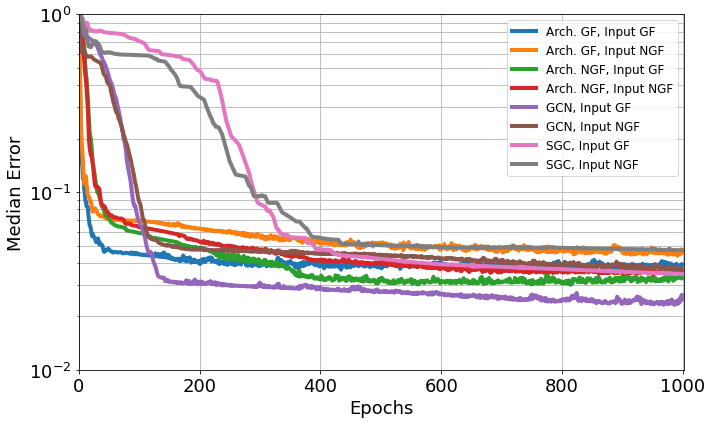

In [12]:
err_med1 = np.median(err1, axis=1)
pert = 1

leg = []
for i, exp in enumerate(Exps):
    leg.append(exp['legend']+', Input GF')
    leg.append(exp['legend']+', Input NGF')

fig = plt.figure(figsize=(10,6))
for i in range(2*len(Exps)):
    plt.semilogy(err_med1[i,:,pert], '-', linewidth=4)

plt.legend(leg, prop={'size': 12})
plt.grid(True, which='both')
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Median Error',fontsize=18)
plt.xlim([0, epochs+1])
plt.ylim([1e-2, 1])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


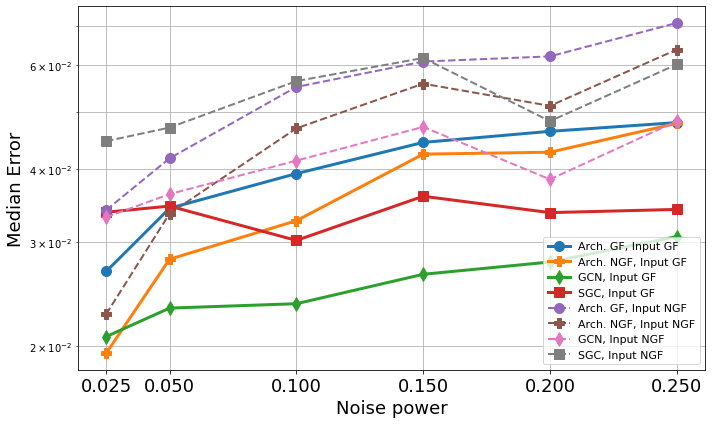

In [13]:
min_err_med1 = np.median(min_err1, axis=1)

leg = []
for i, exp in enumerate(Exps):
    leg.append(exp['legend']+', Input GF')
for i, exp in enumerate(Exps):
    leg.append(exp['legend']+', Input NGF')

fig = plt.figure(figsize=(10,6))

markers = ['o', 'P', 'd', 's']

for i in range(len(Exps)):
    plt.semilogy(n_ps, min_err_med1[2*i,:], markers[i] + '-', linewidth=3, markersize=10)
for i, exp in enumerate(Exps):
    plt.semilogy(n_ps, min_err_med1[2*i+1,:], markers[i] + '--', linewidth=2, markersize=10)

plt.legend(leg, prop={'size': 11})
plt.grid(True, which='both')
plt.xlabel('Noise power',fontsize=18)
plt.ylabel('Median Error',fontsize=18)
plt.xticks(n_ps, fontsize=18)
plt.tight_layout()
plt.savefig('images/denoising_deep.eps', format='eps')